# Autoencoder-based Approach

In this notebook are considered different neural network approaches to predict smoking status based on clinical and biological features. The main goal is to compare a standard feedforward neural network (ANN) with models that leverage an autoencoder for feature extraction.

### Autoencoder

An autoencoder is a type of neural network designed to learn a compressed representation of the input data. It consists of two parts:

* encoder reduces the input into a lower-dimensional latent space, capturing the most important patterns,
* decoder reconstructs the original input from the latent representation.

### Artificial Neural Network (ANN)

An artificial neural network is a standard feedforward network used for classification. It maps input features directly to the target labels, learning complex nonlinear relationships between them.

In this notebook it is planned to:

1. Preprocess the data, encode categorical features, and remove outliers,
2. Train an autoencoder and extract latent features,
3. Build classifiers using both the latent features and the original features,
4. Compare the performance of AE-based classifiers with a baseline ANN,
5. Perform experiments to tune layer sizes and dropout rates to optimize the baseline ANN.

## Preprocessing

A fixed random seed is set for NumPy and TensorFlow to ensure that all operations producing random numbers are repeatable. This guarantees that running the notebook multiple times will yield the same results.

In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

The dataset `smoking.csv` is loaded into a pandas DataFrame.

In [2]:
import pandas as pd
df = pd.read_csv('smoking.csv')

### One-hot encoding

Categorical columns `gender`, `oral`, `tartar` are converted into numerical format using one-hot encoding. The first category in each column is dropped to avoid multicollinearity. The resulting encoded columns are then merged back into the original DataFrame, replacing the original categorical columns.

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

categorical_cols = ['gender', 'oral', 'tartar']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_data = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols), index=df.index)

df = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

### Delete outliers

Numeric features (excluding `ID` and `smoking`) are standardized. Rows with any value more than 3 standard deviations from the mean are considered outliers and removed. The filtered DataFrame `df_filtered` contains only the rows within this threshold.

In [4]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ('ID', 'smoking')]

z_thresh = 3.0
z_scores = ((df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std()).abs()
mask = (z_scores <= z_thresh).all(axis=1)

df_filtered = df[mask].reset_index(drop=True)
print("Before:", len(df), "After:", len(df_filtered))

Before: 55692 After: 47509


The features `X` and target `y` are separated. The dataset is then split into training and test sets, with 20% of the data reserved for testing. Stratification ensures that the class distribution in the target variable is maintained in both sets.

In [5]:
from sklearn.model_selection import train_test_split

FEATURES = [c for c in df_filtered.columns if c not in ('ID', 'smoking')]
X = df_filtered[FEATURES]
y = df_filtered['smoking']

TEST_SIZE = 0.2
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

Numeric features are standardized to have zero mean and unit variance using StandardScaler. The scaler is fit on the training set and applied to both training and test sets to ensure consistent scaling. The variable `input_dim` stores the number of features which will be used as input size for the neural network.

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

input_dim = X_train.shape[1]

# Model training

## Autoencoder

An autoencoder neural network is defined with an encoder and a decoder:
- encoder compresses the input features into a lower-dimensional latent space `bottleneck` through layers of 128 and 64 neurons with ReLU activations and slight L2 regularization,
- decoder reconstructs the original input from the latent representation using layers of 64 and 128 neurons, ending with a linear output layer matching the original input dimension.

In [7]:
from tensorflow.keras import layers, callbacks, regularizers

latent_dim = 32

input_layer = keras.Input(shape=(input_dim,), name='ae_input')
encoded = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(input_layer)
encoded = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(encoded)
encoded = layers.Dense(latent_dim, activation='relu', name='bottleneck')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='linear', name='reconstruction')(decoded)

A separate encoder model is created to extract the latent features from the bottleneck layer. **Mean squared error** is used as the loss function and the *Adam optimizer* is set with a learning rate of 0.001 to train the network.

In [8]:
autoencoder = keras.Model(inputs=input_layer, outputs=decoded, name='autoencoder')
encoder_model = keras.Model(inputs=input_layer, outputs=autoencoder.get_layer('bottleneck').output, name='encoder')

autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

Two callbacks are set up for training:

* **EarlyStopping** stops training if the validation loss does not improve for 10 consecutive epochs and restores the best model weights,
* **ReduceLROnPlateau** reduces the learning rate by half if the validation loss plateaus for 5 epochs, helping the model converge more smoothly.

In [9]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

The autoencoder is trained to reconstruct `X_train`. 10% of the training data is used for validation. Early stopping and learning rate reduction callbacks prevent overfitting. Training runs for up to 100 epochs with a batch size of 256.

In [10]:
history_ae = autoencoder.fit(
    X_train, X_train,
    validation_split=0.1,
    epochs=100,
    batch_size=256,
    callbacks=[es, rl],
    verbose=2
)

Epoch 1/100
134/134 - 3s - 24ms/step - loss: 0.3349 - val_loss: 0.0927 - learning_rate: 0.0010
Epoch 2/100
134/134 - 1s - 4ms/step - loss: 0.0549 - val_loss: 0.0317 - learning_rate: 0.0010
Epoch 3/100
134/134 - 1s - 5ms/step - loss: 0.0217 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 4/100
134/134 - 1s - 4ms/step - loss: 0.0124 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 5/100
134/134 - 1s - 5ms/step - loss: 0.0092 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 6/100
134/134 - 1s - 5ms/step - loss: 0.0077 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 7/100
134/134 - 1s - 5ms/step - loss: 0.0068 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 8/100
134/134 - 1s - 5ms/step - loss: 0.0060 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 9/100
134/134 - 1s - 4ms/step - loss: 0.0053 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 10/100
134/134 - 1s - 5ms/step - loss: 0.0048 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 11/100
134/134 - 1s - 4ms/step - loss: 0.0043 - val_

The autoencoder successfully learned to reconstruct the input data. The training and validation loss both decreased steadily and reached very low values of about 0.001. This means that the model captures the underlying structure of the features. The learning rate was gradually reduced during training to fine-tune the model.

The trained encoder is used to transform the original training and test data into the lower-dimensional latent space `bottleneck`. These encoded representations will be used as input for the classifier.

In [12]:
X_train_encoded = encoder_model.predict(X_train)
X_test_encoded = encoder_model.predict(X_test)

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


### ANN classifier on encoded features

A neural network classifier is created to take the autoencoder’s latent features as input. It has two hidden layers (64 and 32 neurons) with ReLU activations, includes a dropout layer (0.3) to reduce overfitting and ends with a sigmoid output to predict the probability of smoking.

In [13]:
clf_input_dim = X_train_encoded.shape[1]
clf_input = keras.Input(shape=(clf_input_dim,), name='clf_input')

x = layers.Dense(64, activation='relu')(clf_input)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

The classifier model is finalized and compiled using binary **cross-entropy loss** and the **Adam optimizer**. Metrics include accuracy and AUC to evaluate classification performance. Early stopping is set to monitor validation AUC, stopping training if it does not improve for 10 epochs and restoring the best weights.

In [14]:
classifier_enc = keras.Model(inputs=clf_input, outputs=output, name='classifier_encoded')
classifier_enc.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy', keras.metrics.AUC(name='auc')])

es_clf = callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)

The classifier is trained on the autoencoder’s latent representations. 10% of the training data is used for validation. Early stopping and learning rate reduction prevent overfitting. Training runs for up to 100 epochs with a batch size of 256.

In [15]:
history_clf_enc = classifier_enc.fit(
    X_train_encoded, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=256,
    callbacks=[es_clf, rl],
    verbose=2
)

Epoch 1/100
134/134 - 2s - 18ms/step - accuracy: 0.6792 - auc: 0.7552 - loss: 0.5469 - val_accuracy: 0.7085 - val_auc: 0.8072 - val_loss: 0.4956 - learning_rate: 0.0010
Epoch 2/100
134/134 - 1s - 4ms/step - accuracy: 0.7209 - auc: 0.8015 - loss: 0.4946 - val_accuracy: 0.7395 - val_auc: 0.8265 - val_loss: 0.4792 - learning_rate: 0.0010
Epoch 3/100
134/134 - 0s - 3ms/step - accuracy: 0.7281 - auc: 0.8107 - loss: 0.4851 - val_accuracy: 0.7461 - val_auc: 0.8323 - val_loss: 0.4750 - learning_rate: 0.0010
Epoch 4/100
134/134 - 1s - 5ms/step - accuracy: 0.7327 - auc: 0.8152 - loss: 0.4812 - val_accuracy: 0.7493 - val_auc: 0.8336 - val_loss: 0.4703 - learning_rate: 0.0010
Epoch 5/100
134/134 - 1s - 5ms/step - accuracy: 0.7378 - auc: 0.8189 - loss: 0.4787 - val_accuracy: 0.7482 - val_auc: 0.8342 - val_loss: 0.4691 - learning_rate: 0.0010
Epoch 6/100
134/134 - 1s - 5ms/step - accuracy: 0.7410 - auc: 0.8233 - loss: 0.4751 - val_accuracy: 0.7495 - val_auc: 0.8358 - val_loss: 0.4665 - learning_rate

Predictions are made on the test set using the classifier trained on latent features. Both class labels and probabilities are obtained. Accuracy, AUC, classification report and confusion matrix are computed to assess the model’s performance in distinguishing smokers from non-smokers.

In [17]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

y_pred_proba = classifier_enc.predict(X_test_encoded).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Accuracy: 0.7558408756051358
AUC: 0.8409759997796078
              precision    recall  f1-score   support

           0       0.82      0.79      0.81      6096
           1       0.65      0.70      0.67      3406

    accuracy                           0.76      9502
   macro avg       0.74      0.74      0.74      9502
weighted avg       0.76      0.76      0.76      9502

Confusion matrix:
 [[4802 1294]
 [1026 2380]]


The classifier on encoded features performs well, with around 76% accuracy and an AUC of 0.84, indicating good ability to distinguish smokers from non-smokers.

### ANN with pre-training

A neural network classifier is created to take the original features as input. The first three layers replicate the autoencoder’s encoder to extract a latent representation. Two additional hidden layers (64 and 32 neurons) with ReLU activations and a dropout layer (0.4) are added, ending with a sigmoid output to predict the probability of smoking.

In [18]:
clf_full_input = keras.Input(shape=(input_dim,), name='full_input')

l1 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-5), name='enc_l1')
l2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5), name='enc_l2')
l3 = layers.Dense(latent_dim, activation='relu', name='enc_bottleneck')

In [19]:
h = l1(clf_full_input)
h = l2(h)
h = l3(h)

h = layers.Dense(64, activation='relu', name='clf_h1')(h)
h = layers.Dropout(0.4)(h)
h = layers.Dense(32, activation='relu', name='clf_h2')(h)
clf_output = layers.Dense(1, activation='sigmoid', name='clf_out')(h)

The full classifier model is finalized, combining the encoder-like layers and the additional classification layers into a Keras model. The first three layers of the full classifier are loaded with the weights from the trained autoencoder’s encoder. This transfers the learned feature representations to improve classification performance.

In [20]:
classifier_full = keras.Model(inputs=clf_full_input, outputs=clf_output, name='classifier_full')

In [21]:
enc_layers = [layer for layer in autoencoder.layers if isinstance(layer, layers.Dense)][0:3]
classifier_full.get_layer('enc_l1').set_weights(enc_layers[0].get_weights())
classifier_full.get_layer('enc_l2').set_weights(enc_layers[1].get_weights())
classifier_full.get_layer('enc_bottleneck').set_weights(enc_layers[2].get_weights())

The encoder-like layers in the full classifier are frozen to preserve the pretrained weights. The model is compiled with binary cross-entropy loss, Adam optimizer and metrics for accuracy and AUC.

In [22]:
for layer_name in ('enc_l1', 'enc_l2', 'enc_bottleneck'):
    classifier_full.get_layer(layer_name).trainable = False

classifier_full.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy', keras.metrics.AUC(name='auc')])

The full classifier is trained on the original features with the encoder layers frozen. This allows the new classification layers to learn without altering the pretrained feature extraction. Training uses 10% validation, early stopping and learning rate reduction.

In [23]:
history_clf_full_stage1 = classifier_full.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=256,
    callbacks=[es_clf, rl],
    verbose=2
)

Epoch 1/50
134/134 - 3s - 20ms/step - accuracy: 0.6855 - auc: 0.7485 - loss: 0.5556 - val_accuracy: 0.7280 - val_auc: 0.8135 - val_loss: 0.4887 - learning_rate: 0.0010
Epoch 2/50
134/134 - 1s - 7ms/step - accuracy: 0.7193 - auc: 0.7991 - loss: 0.4991 - val_accuracy: 0.7430 - val_auc: 0.8256 - val_loss: 0.4766 - learning_rate: 0.0010
Epoch 3/50
134/134 - 1s - 5ms/step - accuracy: 0.7270 - auc: 0.8095 - loss: 0.4884 - val_accuracy: 0.7432 - val_auc: 0.8295 - val_loss: 0.4728 - learning_rate: 0.0010
Epoch 4/50
134/134 - 1s - 4ms/step - accuracy: 0.7368 - auc: 0.8154 - loss: 0.4835 - val_accuracy: 0.7482 - val_auc: 0.8325 - val_loss: 0.4707 - learning_rate: 0.0010
Epoch 5/50
134/134 - 1s - 5ms/step - accuracy: 0.7355 - auc: 0.8157 - loss: 0.4829 - val_accuracy: 0.7495 - val_auc: 0.8341 - val_loss: 0.4692 - learning_rate: 0.0010
Epoch 6/50
134/134 - 1s - 5ms/step - accuracy: 0.7383 - auc: 0.8202 - loss: 0.4784 - val_accuracy: 0.7503 - val_auc: 0.8335 - val_loss: 0.4693 - learning_rate: 5.00

In [24]:
for layer_name in ('enc_l1', 'enc_l2', 'enc_bottleneck'):
    classifier_full.get_layer(layer_name).trainable = True

classifier_full.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', keras.metrics.AUC(name='auc')])

In [25]:
history_clf_full_stage2 = classifier_full.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=256,
    callbacks=[es_clf, rl],
    verbose=2
)

Epoch 1/100
134/134 - 4s - 29ms/step - accuracy: 0.7191 - auc: 0.8015 - loss: 0.4956 - val_accuracy: 0.7445 - val_auc: 0.8286 - val_loss: 0.4744 - learning_rate: 1.0000e-04
Epoch 2/100
134/134 - 1s - 5ms/step - accuracy: 0.7326 - auc: 0.8148 - loss: 0.4836 - val_accuracy: 0.7540 - val_auc: 0.8342 - val_loss: 0.4698 - learning_rate: 1.0000e-04
Epoch 3/100
134/134 - 1s - 4ms/step - accuracy: 0.7409 - auc: 0.8207 - loss: 0.4801 - val_accuracy: 0.7524 - val_auc: 0.8353 - val_loss: 0.4683 - learning_rate: 1.0000e-04
Epoch 4/100
134/134 - 1s - 5ms/step - accuracy: 0.7435 - auc: 0.8248 - loss: 0.4758 - val_accuracy: 0.7553 - val_auc: 0.8373 - val_loss: 0.4665 - learning_rate: 1.0000e-04
Epoch 5/100
134/134 - 1s - 5ms/step - accuracy: 0.7470 - auc: 0.8278 - loss: 0.4734 - val_accuracy: 0.7537 - val_auc: 0.8378 - val_loss: 0.4659 - learning_rate: 1.0000e-04
Epoch 6/100
134/134 - 1s - 4ms/step - accuracy: 0.7490 - auc: 0.8292 - loss: 0.4718 - val_accuracy: 0.7509 - val_auc: 0.8377 - val_loss: 0.

Predictions are made on the test set using the full classifier with frozen encoder layers. Accuracy, AUC, classification report and confusion matrix are computed to assess the model’s initial performance.

In [26]:
y_pred_proba_full = classifier_full.predict(X_test).ravel()
y_pred_full = (y_pred_proba_full >= 0.5).astype(int)

print('Accuracy:', accuracy_score(y_test, y_pred_full))
print('AUC:', roc_auc_score(y_test, y_pred_proba_full))
print(classification_report(y_test, y_pred_full))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_full))

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.7440538833929699
AUC: 0.8271131989942099
              precision    recall  f1-score   support

           0       0.85      0.73      0.79      6096
           1       0.61      0.77      0.68      3406

    accuracy                           0.74      9502
   macro avg       0.73      0.75      0.73      9502
weighted avg       0.76      0.74      0.75      9502

Confusion matrix:
 [[4462 1634]
 [ 798 2608]]


The full classifier with frozen encoder layers achieves around 74% accuracy and an AUC of 0.83. This shows that the pretrained encoder provides useful feature representations, though there is still room for improvement through fine-tuning.

### Baseline ANN without pre-training

A standard neural network classifier is created using the original features as input. It has three hidden layers (128, 64, 32 neurons) with ReLU activations, includes a dropout layer (0.3) to reduce overfitting and ends with a sigmoid output to predict the probability of smoking.

In [27]:
baseline_input = keras.Input(shape=(input_dim,))
bl = layers.Dense(128, activation='relu')(baseline_input)
bl = layers.Dropout(0.3)(bl)
bl = layers.Dense(64, activation='relu')(bl)
bl = layers.Dense(32, activation='relu')(bl)
bl_out = layers.Dense(1, activation='sigmoid')(bl)

The baseline model is finalized and compiled using binary cross-entropy loss, Adam optimizer and metrics for accuracy and AUC to evaluate its classification performance.

In [28]:
baseline_model = keras.Model(inputs=baseline_input, outputs=bl_out)
baseline_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy', keras.metrics.AUC(name='auc')])

The baseline neural network is trained on the original features. 10% of the training data is used for validation. Early stopping and learning rate reduction callbacks prevent overfitting.

In [29]:
history_baseline = baseline_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=256,
    callbacks=[es_clf, rl],
    verbose=2
)

Epoch 1/100
134/134 - 3s - 22ms/step - accuracy: 0.7184 - auc: 0.8002 - loss: 0.5002 - val_accuracy: 0.7553 - val_auc: 0.8360 - val_loss: 0.4675 - learning_rate: 0.0010
Epoch 2/100
134/134 - 1s - 7ms/step - accuracy: 0.7475 - auc: 0.8292 - loss: 0.4703 - val_accuracy: 0.7574 - val_auc: 0.8404 - val_loss: 0.4622 - learning_rate: 0.0010
Epoch 3/100
134/134 - 1s - 5ms/step - accuracy: 0.7524 - auc: 0.8334 - loss: 0.4658 - val_accuracy: 0.7582 - val_auc: 0.8426 - val_loss: 0.4596 - learning_rate: 0.0010
Epoch 4/100
134/134 - 1s - 6ms/step - accuracy: 0.7572 - auc: 0.8385 - loss: 0.4613 - val_accuracy: 0.7577 - val_auc: 0.8435 - val_loss: 0.4583 - learning_rate: 0.0010
Epoch 5/100
134/134 - 1s - 4ms/step - accuracy: 0.7572 - auc: 0.8388 - loss: 0.4608 - val_accuracy: 0.7551 - val_auc: 0.8451 - val_loss: 0.4562 - learning_rate: 0.0010
Epoch 6/100
134/134 - 1s - 5ms/step - accuracy: 0.7580 - auc: 0.8416 - loss: 0.4573 - val_accuracy: 0.7574 - val_auc: 0.8460 - val_loss: 0.4556 - learning_rate

Predictions are made on the test set using the baseline model. Accuracy, AUC, classification report and confusion matrix are computed to assess its performance in predicting smoking status.

In [30]:
y_pred_proba_baseline = baseline_model.predict(X_test).ravel()
y_pred_baseline = (y_pred_proba_baseline >= 0.5).astype(int)

print('Accuracy:', accuracy_score(y_test, y_pred_baseline))
print('AUC:', roc_auc_score(y_test, y_pred_proba_baseline))
print(classification_report(y_test, y_pred_baseline))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_baseline))

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7633129867396338
AUC: 0.8468544682611973
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      6096
           1       0.65      0.72      0.69      3406

    accuracy                           0.76      9502
   macro avg       0.74      0.75      0.75      9502
weighted avg       0.77      0.76      0.77      9502

Confusion matrix:
 [[4800 1296]
 [ 953 2453]]


The baseline ANN achieves around 76% accuracy and an AUC of 0.85, performing slightly better than the previous models. This indicates that a well-tuned standard neural network on the original features can capture the patterns in the data.

## Model comparison

Predicted labels and probabilities from the three models—AE + ANN, pretrained AE + ANN, and baseline ANN—are stored in separate variables to facilitate performance comparison.

In [31]:
# AE + ANN
y_pred_ae = y_pred
y_pred_proba_ae = y_pred_proba

# Pretrained AE + ANN
y_pred_pretrained = y_pred_full
y_pred_proba_pretrained = y_pred_proba_full

# Baseline ANN
y_pred_baseline_model = y_pred_baseline
y_pred_proba_baseline_model = y_pred_proba_baseline

Accuracy and AUC are computed for each of the three models on the test set. These metrics will be used to compare the overall performance of the models.

In [32]:
models = ['AE + ANN', 'Pretrained AE + ANN', 'Baseline ANN']
accuracy = [
    accuracy_score(y_test, y_pred_ae),
    accuracy_score(y_test, y_pred_pretrained),
    accuracy_score(y_test, y_pred_baseline_model)
]
auc = [
    roc_auc_score(y_test, y_pred_proba_ae),
    roc_auc_score(y_test, y_pred_proba_pretrained),
    roc_auc_score(y_test, y_pred_proba_baseline_model)
]

In [33]:
df_metrics = pd.DataFrame({'Model': models, 'Accuracy': accuracy, 'AUC': auc})
print(df_metrics)

                 Model  Accuracy       AUC
0             AE + ANN  0.755841  0.840976
1  Pretrained AE + ANN  0.744054  0.827113
2         Baseline ANN  0.763313  0.846854


The baseline ANN shows the best performance among the three models, achieving the highest accuracy (~76%) and AUC (~0.85). Both autoencoder-based approaches perform slightly worse, but still provide reasonably good results.

A bar chart is created to compare accuracy and AUC across the three models.

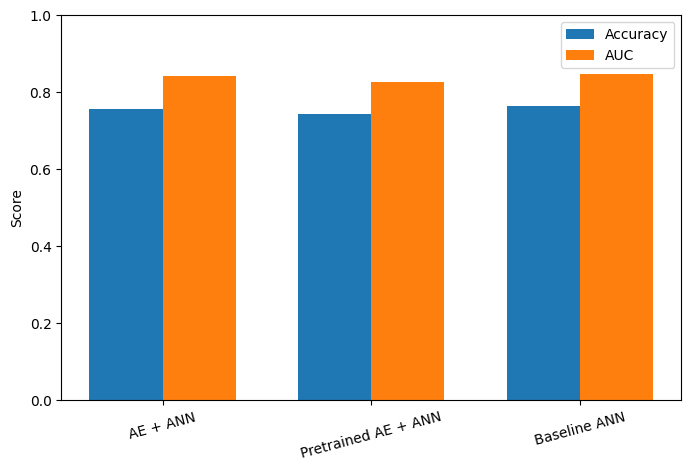

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))
width = 0.35
x = np.arange(len(models))

ax.bar(x - width/2, accuracy, width, label='Accuracy')
ax.bar(x + width/2, auc, width, label='AUC')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.legend()
plt.show()

# Experiments

The **baseline ANN**, which achieved the best performance (Accuracy ~76%, AUC ~0.85), will be further tuned. Different network architectures `layer_configs` and `dropout_rates` are specified to systematically explore how changes in layer size, depth and regularization affect the model’s performance.

In [36]:
layer_configs = [
    [128, 64, 32],
    [256, 128, 64, 32],
    [64, 32],
]
dropout_rates = [0.0, 0.2, 0.3, 0.5]

An empty list results is created to store the outcomes of each configuration. Early stopping and learning rate reduction callbacks are defined to optimize training during the experiment, monitoring validation AUC.

In [37]:
results = []

es_clf = callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)
rl = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=5)

A grid search is performed over all combinations of layer configurations and dropout rates. For each combination:

* a new ANN is created with the specified layers and dropout,
* the model is compiled and trained on the training set for up to 50 epochs with early stopping and learning rate reduction,
* accuracy and AUC are computed on the test set and stored in `results`.

This evaluates how network depth, width, and regularization affect performance.

In [41]:
from itertools import product
from tensorflow.keras import layers, models, callbacks

for layers_cfg, dropout in product(layer_configs, dropout_rates):
    tf.keras.backend.clear_session()
    
    inp = layers.Input(shape=(input_dim,))
    x = inp
    for neurons in layers_cfg:
        x = layers.Dense(neurons, activation='relu')(x)
        if dropout > 0:
            x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=256, callbacks=[es_clf, rl], verbose=0)
    
    y_pred_proba = model.predict(X_test).ravel()
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    acc = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    results.append({
        'layers': layers_cfg,
        'dropout': dropout,
        'accuracy': acc,
        'auc': auc_score
    })

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


The outcomes of all tested architectures and dropout rates are compiled into a DataFrame, sorted by AUC in descending order.

In [42]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='auc', ascending=False).reset_index(drop=True)
print(df_results)

                layers  dropout  accuracy       auc
0        [128, 64, 32]      0.0  0.756262  0.842917
1   [256, 128, 64, 32]      0.0  0.754262  0.837904
2   [256, 128, 64, 32]      0.2  0.745527  0.834882
3        [128, 64, 32]      0.2  0.748158  0.834097
4   [256, 128, 64, 32]      0.3  0.746369  0.832440
5             [64, 32]      0.0  0.746685  0.827420
6        [128, 64, 32]      0.3  0.743107  0.827346
7             [64, 32]      0.3  0.735424  0.820906
8             [64, 32]      0.2  0.733109  0.818221
9   [256, 128, 64, 32]      0.5  0.706378  0.816844
10       [128, 64, 32]      0.5  0.727005  0.813732
11            [64, 32]      0.5  0.726794  0.812817


The experiment results show that the original baseline architecture `[128, 64, 32] without dropout` remains the best, achieving the highest AUC of 0.843 and accuracy of 0.756. Adding more layers or dropout did not improve performance and in some cases, slightly reduced it.

A bar chart is created to compare accuracy and AUC for all tested network configurations.

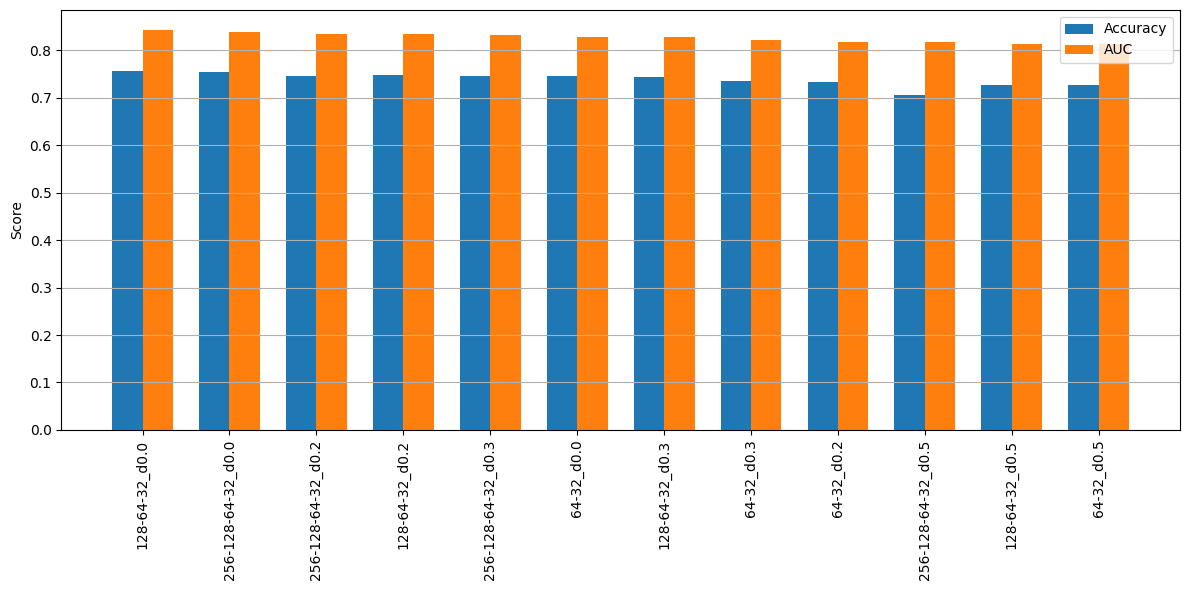

In [45]:
import matplotlib.pyplot as plt
import numpy as np

df_results['config_str'] = df_results.apply(lambda row: f"{'-'.join(map(str, row['layers']))}_d{row['dropout']}", axis=1)
df_plot = df_results.sort_values(by='auc', ascending=False)

plt.figure(figsize=(12,6))
x = np.arange(len(df_plot))
width = 0.35

plt.bar(x - width/2, df_plot['accuracy'], width, label='Accuracy')
plt.bar(x + width/2, df_plot['auc'], width, label='AUC')

plt.xticks(x, df_plot['config_str'], rotation=90)
plt.ylabel('Score')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The top-performing network configuration is selected based on AUC. The number of neurons in each layer, dropout rate, accuracy and AUC are printed.

In [43]:
best_config = df_results.sort_values(by='auc', ascending=False).iloc[0]

print(f"Neurons: {best_config['layers']}")
print(f"Dropout: {best_config['dropout']}")
print(f"Accuracy: {best_config['accuracy']:.4f}")
print(f"AUC: {best_config['auc']:.4f}")

Neurons: [128, 64, 32]
Dropout: 0.0
Accuracy: 0.7563
AUC: 0.8429


The best-performing configuration uses three layers with 128, 64, and 32 neurons and no dropout. It achieves an accuracy of ~75.6% and an AUC of ~0.843.

# Conclusions

Among all tested models, the standard neural network trained directly on the original features achieved the highest accuracy. ANN can effectively capture patterns in the dataset without needing pretraining.
- models using autoencoder-based feature extraction (AE + ANN and pretrained AE + ANN) performed worse than the baseline. It means that for this datase, direct learning from original features is more effective than compressing features into a latent space,
- using the autoencoder’s encoder weights in the full classifier improved performance over training from scratch with the same architecture,
- adding more layers or dropout to grid-search experiments did not improve performance, sometimes even reduced it.